<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Activity Classifier

In this notebook, we build a CNN neural net to classify PE activity.

#### Load dependencies

In [119]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint 
import os  
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

#### Set hyperparameters

In [120]:
# output directory name:
output_dir = 'model_output/cnn2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency

# pooling layer parameters
maxpooling_pool_size = 2
avepooling_pool_size = 2


# convolutional layer architecture:
n_conv_1 = 256 # filters, a.k.a. kernels
k_conv_1 = 3 # kernel length
n_conv_2 = 256
k_conv_2 = 3 # kernel length
n_conv_3 = 256 # filters, a.k.a. kernels
k_conv_3 = 2 # kernel length

# dense layer architecture: 
n_dense_1 = 512
dropout_1 = 0.3
n_dense_2 = 256
dropout_2 = 0.25

# training:
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [121]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [122]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [123]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note: to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [124]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
y.shape

(64754, 6)

In [125]:
input_shape = list(accel_array.shape)
input_shape

[64754, 90, 3]


#### Design neural network architecture

In [127]:
# a conv model!

model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation='relu', input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation='relu'))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation='relu'))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense_1, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation='relu'))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 44, 256)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d_8 (Average (None, 21, 256)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d_10  (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)             

### Splitting and shuffeling the data

In [128]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Configure model

In [129]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [130]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [131]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [132]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint])

# model.fit(x_train, y_train, 
#           batch_size=batch_size, epochs=epochs, verbose=1, 
#           validation_data=(x_valid, y_valid))

Epoch 1/60
228/228 [==============================] - 6s 25ms/step - loss: 1.0732 - accuracy: 0.5505 - val_loss: 0.8005 - val_accuracy: 0.6805
Epoch 2/60
228/228 [==============================] - 5s 23ms/step - loss: 0.7005 - accuracy: 0.7145 - val_loss: 0.5832 - val_accuracy: 0.7648
Epoch 3/60
228/228 [==============================] - 5s 23ms/step - loss: 0.4800 - accuracy: 0.8212 - val_loss: 0.6195 - val_accuracy: 0.7773
Epoch 4/60
228/228 [==============================] - 5s 23ms/step - loss: 0.3663 - accuracy: 0.8636 - val_loss: 0.3177 - val_accuracy: 0.8885
Epoch 5/60
228/228 [==============================] - 5s 23ms/step - loss: 0.3118 - accuracy: 0.8855 - val_loss: 0.2939 - val_accuracy: 0.8931
Epoch 6/60
228/228 [==============================] - 5s 23ms/step - loss: 0.2833 - accuracy: 0.8956 - val_loss: 0.3149 - val_accuracy: 0.8792
Epoch 7/60
228/228 [==============================] - 5s 23ms/step - loss: 0.2762 - accuracy: 0.9000 - val_loss: 0.2445 - val_accuracy: 0.9070

Epoch 58/60
228/228 [==============================] - 5s 23ms/step - loss: 0.0781 - accuracy: 0.9705 - val_loss: 0.1600 - val_accuracy: 0.9575
Epoch 59/60
228/228 [==============================] - 5s 23ms/step - loss: 0.0762 - accuracy: 0.9711 - val_loss: 0.1673 - val_accuracy: 0.9541
Epoch 60/60
228/228 [==============================] - 5s 24ms/step - loss: 0.0720 - accuracy: 0.9727 - val_loss: 0.1595 - val_accuracy: 0.9594


#### Evaluate

In [149]:
model.load_weights(output_dir+"/weights.49.hdf5") # 96.19 val accuracy

In [150]:
y_hat = model.predict(x_valid)

In [151]:
len(y_hat)

6476

In [152]:
y_hat[0]

array([3.2657222e-03, 1.1235670e-08, 2.5627809e-09, 1.4760160e-09,
       1.3126909e-05, 9.9672121e-01], dtype=float32)

In [153]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

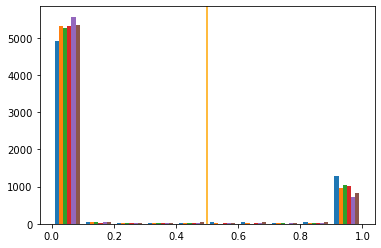

In [154]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [155]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [156]:
"{:0.2f}".format(pct_auc)

'99.79'

In [157]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [158]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [159]:
ydf.head(10)

,y_hat,y
0,3.265722e-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,1.317523e-29,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,8.489454e-09,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,9.999703e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,7.741981e-07,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,2.786986e-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,2.301731e-27,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,2.157759e-03,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,9.999918e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,1.824784e-04,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
